# Heatwave exposure in Europe

Use ERA5-Land data

https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/population-distribution-demography/geostat

https://ec.europa.eu/eurostat/data/database?node_code=demo_r_minf
Demographic data at regional level include statistics on the population at the end of the calendar year and on live births and deaths during that year, according to the official classification for statistics at regional level (NUTS - nomenclature of territorial units for statistics). These data are broken down by NUTS 2 and 3 levels. The current online demographic data refers to the NUTS 2016 classification, which subdivides the territory of the European Union into:



In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import xesmf as xe
import rasterio
# from cartopy import crs as ccrs

from rasterio import features
from tqdm.notebook import tqdm

In [2]:
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

In [3]:
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = np.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat + pixel_size/2, center_lat - pixel_size/2]:
        zm = 1 - e*np.sin(np.radians(f))
        zp = 1 + e*np.sin(np.radians(f))
        area = (np.pi * b**2 * (
                np.log(zp/zm) / (2*e) +
                np.sin(np.radians(f)) / (zp*zm)))
        
        area_list.append(area)
    return (pixel_size / 360.) * (area_list[0] - area_list[1])

In [4]:
from ipywidgets import interact, IntSlider, fixed
def _plot_year(year, data):
    data.sel(year=year).plot(robust=True)
    plt.show()
    
def interactive_map(data):
    start_year=data.year.min().item()
    end_year=data.year.max().item()
    
    interact(_plot_year, year=IntSlider(min=start_year, max=end_year, step=1, value=end_year), data=fixed(data));

In [5]:
xr.set_options(keep_attrs=True)

# Figure settings
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [6]:
MAX_YEAR = 2021

MAX_YEAR = 2020

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

TEMPERATURES_FOLDER = WEATHER_SRC / 'era5_land' / 'era5_land_daily_summary'
CLIMATOLOGY_QUANTILES = WEATHER_SRC / 'era5_land' / 'era5_land_daily_quantiles'

HEATWAVES_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2022'

INTERMEDIATE_RESULTS_FOLDER =  DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_europe_2022'

In [7]:
RESULTS_FOLDER =  Path('results/')

In [8]:
# INTERMEDIATE_RESULTS_FOLDER.mkdir()

In [9]:
files = sorted((HEATWAVES_FOLDER/ 'heatwave_days_era5land').glob('*.nc'))

In [10]:
heatwave_days = xr.open_mfdataset(files).heatwaves_days

In [12]:
heatwaves_days_reference = heatwave_days.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_days_delta = heatwave_days - heatwaves_days_reference

# NUTS shapefiles

In [27]:
shapefile = Path('.') / 'shapefiles/NUTS_RG_03M_2016_4326 clipped.geojson'

In [28]:
nuts = gpd.read_file(shapefile)

In [29]:
nuts.head()

id  LEVL_CODE NUTS_ID CNTR_CODE                NAME_LATN  \
0  BG          0      BG        BG                 BULGARIA   
1  CH          0      CH        CH  SCHWEIZ/SUISSE/SVIZZERA   
2  CY          0      CY        CY                   KYPROS   
3  AL          0      AL        AL                SHQIPËRIA   
4  CZ          0      CZ        CZ          ČESKÁ REPUBLIKA   

                 NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
0                 БЪЛГАРИЯ           0          0           0  BG   
1  SCHWEIZ/SUISSE/SVIZZERA           0          0           3  CH   
2                   ΚΥΠΡΟΣ           0          0           0  CY   
3                SHQIPËRIA           0          0           0  AL   
4          ČESKÁ REPUBLIKA           0          0           0  CZ   

                                            geometry  
0  POLYGON ((22.99717 43.80787, 23.05372 43.79691...  
1  POLYGON ((8.61383 47.80108, 8.62791 47.76184, ...  
2  POLYGON ((33.75237 34.97711, 33.70164 34.97605...  
3  MULTIPOLYGON (((19.83100 42.46645, 19.84072 42...  
4  POLYGON ((14.49122 51.04353, 14.50443 51.04093...

In [30]:
bounds = nuts.geometry.total_bounds

# Subset the weather data

NOTE: since input data is 'image style' it's indexed from top-left so latitude is in decreasing order and lat label ranges need to be in order [max val: min val]
NOTE: since we cross 0 longitude and ERA data is on 0-360 grid, need to stich together a new dataset and change coords to be on -180 to 180

In [16]:
# lat_slice = slice(bounds[3], bounds[1])
# # lon_slice = slice(bounds[0], bounds[2])

# lon_slice1 = slice(360 + bounds[0], 360)
# lon_slice2 = slice(0, bounds[2])

# part1 = heatwave_days_delta.sel(latitude=lat_slice, longitude=lon_slice1)

# part1['longitude']  = part1.longitude - 360

# heatwave_days_delta_eu = xr.concat([
# #     heatwave_days_delta.sel(latitude=lat_slice, longitude=lon_slice1),
#     part1,
#     heatwave_days_delta.sel(latitude=lat_slice, longitude=lon_slice2)],
#     'longitude'
# ).load()

# heatwave_days_delta_eu.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_delta_eu.nc')

In [50]:
heatwave_days_delta_eu = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_delta_eu.nc', decode_cf=True)

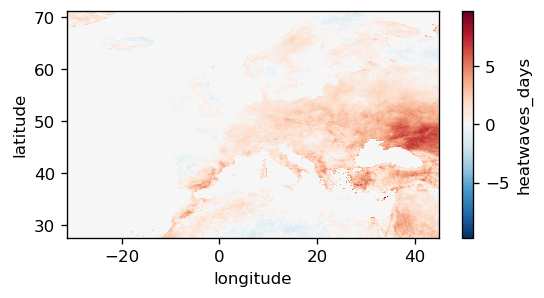

In [51]:
heatwave_days_delta_eu.heatwaves_days.mean(dim='year').plot()

In [22]:
lat_slice = slice(bounds[3], bounds[1])
# lon_slice = slice(bounds[0], bounds[2])

lon_slice1 = slice(360 + bounds[0], 360)
lon_slice2 = slice(0, bounds[2])

part1 = heatwave_days.sel(latitude=lat_slice, longitude=lon_slice1)

part1['longitude']  = part1.longitude - 360

heatwave_days_eu = xr.concat([
#     heatwave_days_delta.sel(latitude=lat_slice, longitude=lon_slice1),
    part1,
    heatwave_days.sel(latitude=lat_slice, longitude=lon_slice2)],
    'longitude'
).load()

heatwave_days_eu.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_eu.nc')

In [39]:
heatwave_days_eu = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_eu.nc')

# Generate NUTS code grid

- split out each NUTS level
- assign numeric code
- burn to grid based on ref grid

In [40]:
nuts2 =nuts[nuts.LEVL_CODE == 2].copy()

nuts2['id_as_int'] = nuts2.id.str.encode("utf-8").apply(lambda b: np.frombuffer(b, dtype='>u4')[0]).astype(np.uint32)

In [25]:
north = heatwave_days_delta_eu.latitude[0].item()
west = heatwave_days_delta_eu.longitude[0].item()

ysize = -(heatwave_days_delta_eu.latitude[1] - heatwave_days_delta_eu.latitude[0]).item()
xsize = (heatwave_days_delta_eu.longitude[1] - heatwave_days_delta_eu.longitude[0]).item()

transform = rasterio.transform.from_origin(west, north, xsize, ysize)

image = features.rasterize(
            [(row.geometry, row.id_as_int) for idx, row in nuts2.iterrows()],
            out_shape=heatwave_days_delta_eu.heatwaves_days.shape[1:],
            transform=transform,
    dtype=np.uint32
)

# Make NetCDF matching the heatwave data

raster_nuts_grid = xr.DataArray(image, 
                                {'latitude': heatwave_days_delta_eu.latitude, 
                                 'longitude':heatwave_days_delta_eu.longitude, 
                                },
                                name='eu_nuts2_id_as_int'
                               )
raster_nuts_grid.to_netcdf('eu_nuts2_id_as_int.nc', encoding={'eu_nuts2_id_as_int':{'_FillValue': 0}})

In [41]:
raster_nuts_grid = xr.open_dataarray('eu_nuts2_id_as_int.nc').squeeze()

### Overview of NUTS regions

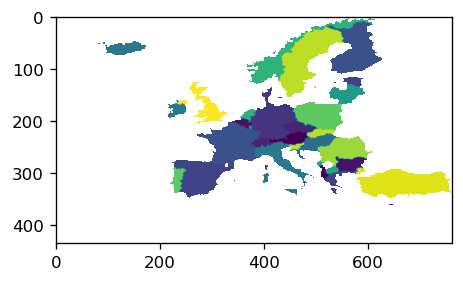

In [42]:
plt.imshow(raster_nuts_grid)

# Load the GPWv4 5min data, slice, and regrid

> NOTE: Using GPW data because GEOSTAT is on EU grid reference and it's a huge pain to re-grid it, for little gain in the end (especially since I already have the preparation routines for GPW). Eventually the advantage of going to GEOSTAT is that it's based on several years worth of cencus data while (I now know) GPW is modelled on 2010 + UN population change projections -> so the GEOSTAT should be more accurate (I don't think GPW bothered to add extra corrections). Other alternative is Landscan which *does* do yearly data ingestion with various things. Can see with the group discussions about using it -> doesn't go back very far which is a shame for the heatwaves work. Finally, i think it's also worth the get the regridding working - GPW is a good start since I know the data and it's on a 'sensible' grid. Good way to get into using the ESMF regrid routines instead of homebaked/half baked methods of my own. 


In [43]:
POPULATION_FILE = POP_DATA_SRC / 'gpwv4' / 'gpw_v4_population_count_adjusted_rev11_2pt5_min.nc'

POPULATION_DENSE_FILE = POP_DATA_SRC / 'gpwv4' / 'gpw_v4_population_density_adjusted_rev11_2pt5_min.nc'

POPULATION_LAYERS_FILE = POP_DATA_SRC / 'gpwv4' / 'gpw_v4_netcdf_contents_rev11.csv'

In [44]:
POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'
DENSE_VAR = 'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'

In [45]:
layer_data = pd.read_csv(POPULATION_LAYERS_FILE).set_index('file_name')

In [46]:
# layer_data

In [47]:
population = xr.open_dataset(POPULATION_FILE)

population_dense = xr.open_dataset(POPULATION_DENSE_FILE)

# Regrid using population density

Use 'conservative' method to regrid on population density then re-multiply by pixel areas to get totals. Result is -3.6% different w.r.t the original population count. Think this is FINE for now - would like to cross check with the 30second data (1km) using just grouping of points without fancy regrid, but it's a ton of extra data to mess with.

In [48]:
lat_slice = slice(bounds[3], bounds[1])
lon_slice = slice(bounds[0], bounds[2])

In [52]:
reference_grid = heatwave_days_delta_eu.sel(year=2000, drop=True).drop_vars('heatwaves_days')

reference_grid['latitude'] = reference_grid.latitude.astype(float)
reference_grid['longitude'] = reference_grid.longitude.astype(float)

In [53]:
PIXEL_SIZE = 0.1

# Areas in km2 - calculation is in m2
areas = area_of_pixel(PIXEL_SIZE, reference_grid.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': reference_grid.latitude})

In [54]:
ds_out = xr.Dataset(
    {
        "latitude": (["latitude"], reference_grid.latitude.data),
        "longitude": (["longitude"], reference_grid.longitude.data),
    }
)

ref_slice = population_dense.sel(raster=1, drop=True).sel(latitude=lat_slice, longitude=lon_slice)

# NOTE: CF extension pretty flaky, doesn't
regridder = xe.Regridder(ref_slice, ds_out, method="conservative")
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_1045x1826_435x761.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1045, 1826) 
Output grid shape:          (435, 761) 
Periodic in longitude?      False

In [55]:
rasters_i = [1,2,3,4,5]

In [56]:
population_dense = population_dense.sel(raster=rasters_i, drop=True).sel(latitude=lat_slice, longitude=lon_slice)

In [57]:
pop_dense_regrid = regridder(population_dense[DENSE_VAR])

In [58]:
pop_regrid = pop_dense_regrid * areas

pop_regrid = pop_regrid.rename({'raster': 'year'})

pop_regrid['year'] = [2000, 2005, 2010, 2015, 2020]

In [40]:
p1 = population.sel(latitude=lat_slice, longitude=lon_slice, raster=rasters_i).sum(dim=['latitude', 'longitude'])

In [41]:
p2 = pop_regrid.sum(dim=['latitude', 'longitude'])

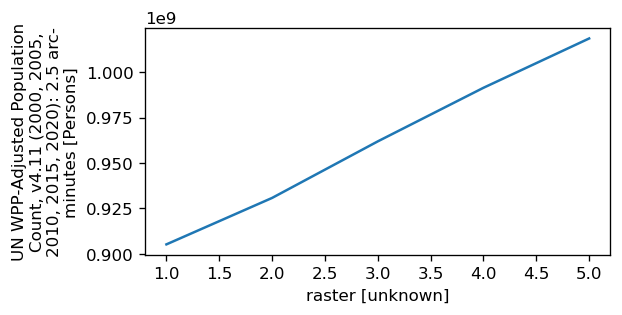

In [42]:
p1[POPULATION_VAR].plot()

In [89]:
# population.sel(latitude=lat_slice, longitude=lon_slice, raster=1) - pop_regrid.sel(year=2000)

In [43]:
p1 = p1.to_dataframe()
p2 = p2.to_dataframe(name='regrid')
df = p2.copy()
p1.index = [2000, 2005, 2010, 2015, 2020]
df['original'] = p1

<AxesSubplot:xlabel='year'>

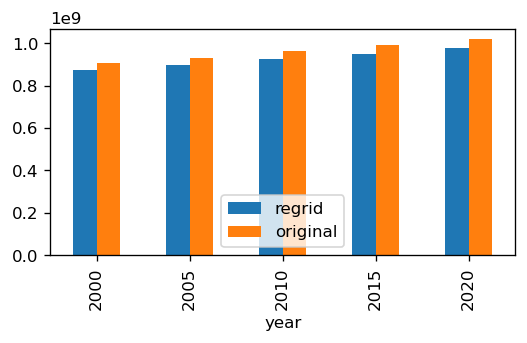

In [44]:
df.plot.bar()

In [45]:
df.original / df.regrid

year
2000    1.037288
2005    1.039250
2010    1.040744
2015    1.042444
2020    1.043278
dtype: float64

# Interpolate pop counts to get yearly

In [59]:
pop_regrid = pop_regrid.interp({'year':np.arange(2000, 2022)}, kwargs=dict(fill_value='extrapolate'))

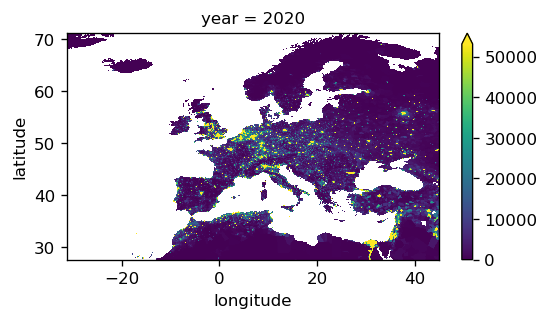

In [60]:
pop_regrid.sel(year=2020).plot(robust=True)

In [61]:
pop_regrid.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'population_regridded.nc')

# Regrid GPW demographics

In [62]:
# From the info file, over-65s is layer 15
# TODO need to get the new demographics filf
DEMOG_FILE = POP_DATA_SRC / 'gpwv4' / 'gpw_v4_basic_demographic_characteristics_rev11_bt_2010_dens_2pt5_min.nc'
var = 'Basic Demographic Characteristics, v4.10 (2010): Both, Density, 2.5 arc-minutes'

# over_65 = xr.open_dataset(DEMOG_FILE).sel(raster=15, drop=True).sel(latitude=lat_slice, longitude=lon_slice)[var]

In [63]:
demog = xr.open_dataset(DEMOG_FILE).sel(raster=slice(2, 15), drop=True).sel(latitude=lat_slice, longitude=lon_slice)[var]
demog['raster'] = np.arange(0, 65+1,5)
demog = demog.rename({'raster': 'age_band_lower_bound'})

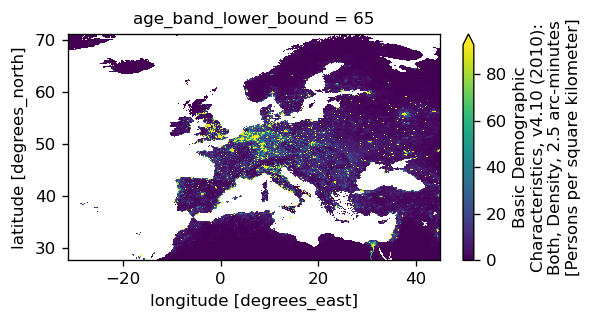

In [64]:
demog.sel(age_band_lower_bound=65).plot(robust=True)

In [65]:
demog_regrid = regridder(demog) * areas

In [66]:
demog_regrid.sum() / pop_regrid.sel(year=2010).sum()

<xarray.DataArray ()>
array(0.99621061)
Coordinates:
    year     int64 2010
Attributes:
    regrid_method:  conservative

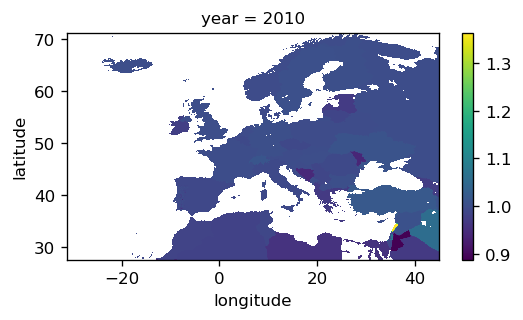

In [54]:
(demog_regrid.sum(dim='age_band_lower_bound') / pop_regrid.sel(year=2010)).plot()

In [67]:
f_demog = demog_regrid / pop_regrid.sel(year=2010)

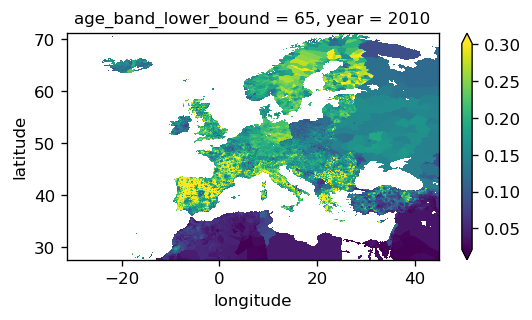

In [56]:
f_demog.sel(age_band_lower_bound=65).plot(robust=True)

## Simple approach - extend demog fractions to all years (not corrected with yearly data)

In [68]:
pop_over_65 = f_demog.sel(age_band_lower_bound=65).drop('year') * pop_regrid

In [58]:
interactive_map(pop_over_65)

interactive(children=(IntSlider(value=2021, description='year', max=2021, min=2000), Output()), _dom_classes=(…

In [69]:
heatwave_change_exposure_over_65 = pop_over_65 * heatwave_days_delta_eu.heatwaves_days

In [60]:
interactive_map(heatwave_change_exposure_over_65)

interactive(children=(IntSlider(value=2020, description='year', max=2020, min=2000), Output()), _dom_classes=(…

# Apply matched NUTS2 demographic data


Annoyingly Eurostat decided to include data quality indicator codes (as letters) along side the numbers: https://ec.europa.eu/eurostat/data/database/information. At least are separated with a space, so can split on space and keep first part. 

In [16]:
def prep_eurostat_table(data):
    cols = [c.strip() for c in data.columns]
    cols[0] = 'key'
    data.columns = cols

    for c in data:
        if hasattr(data[c], 'str'):
            data[c] = data[c].astype(str)
            data[c] = data[c].apply(lambda s: s.split(' ')[0])

    data.index = pd.MultiIndex.from_tuples(data.key.str.split(','))
    data = data.drop('key', axis=1)

    data.columns = data.columns.astype(int)
    data = (data.replace(':', np.nan)
            .astype(float))
    
    data = data[sorted(data.columns)]
    return data

In [70]:
# pd.read_table('demo_r_pjanaggr3.tsv')
eu_demog = pd.read_table('demo_r_pjangroup.tsv', na_values=[': ',': c', ':'])

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (3,9,11,13,21,22,23,24,25,26,27,28,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [71]:
eu_demog = prep_eurostat_table(eu_demog)
eu_demog = eu_demog.droplevel(0).loc['T']
eu_demog.index.names=['age_group', 'nuts']
eu_demog = eu_demog[sorted(eu_demog.columns)]

In [72]:
eu_demog_total = (eu_demog.to_xarray()
              .to_array('year').sel(age_group='TOTAL')
              .ffill('year').bfill('year'))

eu_demog_x = (eu_demog.to_xarray()
              .to_array('year')
              .ffill('year').bfill('year'))

In [73]:
over_65_names = ['Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y_GE85']
eu_demog_over65 = eu_demog_x.sel(age_group=over_65_names).sum(dim='age_group')

In [74]:
eu_demog_x = eu_demog_x.drop_sel(age_group=over_65_names + ['TOTAL', 'UNK', 'Y_GE75', 'Y_GE80'])

In [75]:
# Generate age band lower bound with same order as agr group label in Eurostat data
age_band_lower_bound = [g.item().replace('Y', '').split('-')[0] for g in eu_demog_x.age_group]
i = age_band_lower_bound.index('_LT5')
age_band_lower_bound[i] = 0
age_band_lower_bound = list(map(int, age_band_lower_bound))

In [76]:
eu_demog_x['age_group'] = age_band_lower_bound
eu_demog_x = eu_demog_x.sortby('age_group')

In [77]:
eu_demog_x = xr.concat([eu_demog_x, eu_demog_over65.expand_dims({'age_group': [65]})], 
                       dim='age_group')

In [78]:
eu_demog_x = eu_demog_x.rename({'age_group': 'age_band_lower_bound'})

In [79]:
eu_demog_f = eu_demog_x.sel(nuts=nuts2.id.values) / eu_demog_total.sel(nuts=nuts2.id.values).drop('age_group')

eu_demog_f = eu_demog_f.interp({'year':np.arange(2000, 2022)}, kwargs=dict(fill_value='extrapolate'))

eu_demog_f = eu_demog_f.sel(year=pop_regrid.year.data)

In [80]:
from ipywidgets import Dropdown

In [73]:
plot_data = nuts2.set_index('id')

def _plot_year_age(year, age_band, data):
    plot_data['var'] = eu_demog_f.sel(year=year, age_band_lower_bound=age_band, drop=True).to_dataframe('var')
    plot_data.plot('var', legend=True)
    plt.show()
    
    
start_year=eu_demog_f.year.min().item()
end_year=eu_demog_f.year.max().item()

interact(_plot_year_age, 
         year=IntSlider(min=start_year, max=end_year, step=1, value=end_year),
         age_band=Dropdown(options=eu_demog_f.age_band_lower_bound.data, value=65),
         data=fixed(plot_data));

interactive(children=(IntSlider(value=2021, description='year', max=2021, min=2000), Dropdown(description='age…

In [81]:
demographics = xr.DataArray(
    np.zeros((
        len(pop_regrid.year),
        len(pop_regrid.latitude), 
        len(pop_regrid.longitude),
        len(eu_demog_f.age_band_lower_bound),
        )),
    coords=[
        pop_regrid.year,
        pop_regrid.latitude,
        pop_regrid.longitude, 
        eu_demog_f.age_band_lower_bound,
    ],
    name='demographics'
)

for _, row in tqdm(nuts2.iterrows(), total=len(nuts2)):
    mask = raster_nuts_grid == row.id_as_int
    
    demog = pop_regrid.where(mask) * eu_demog_f.sel(nuts=row.id, drop=True)
      
    demographics = xr.where(mask, demog, demographics)

  0%|          | 0/327 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# results.name='population_over_65'

In [125]:
plot_data = demographics

_age_band_max = {a: 
    plot_data.sel(year=2020, age_band_lower_bound=a).quantile(0.98).item()
                 for a in plot_data.age_band_lower_bound.data
                }

def _plot_demog(year, age_band, data):
    age_max = _age_band_max[age_band]
    data.sel(year=year, age_band_lower_bound=age_band).plot(vmin=0, vmax=age_max)
    plt.show()
    
    
start_year=demographics.year.min().item()
end_year=demographics.year.max().item()

interact(_plot_demog, 
         year=IntSlider(min=start_year, max=end_year, step=1, value=end_year),
         age_band=Dropdown(options=plot_data.age_band_lower_bound.data, value=65),
         data=fixed(plot_data));

interactive(children=(IntSlider(value=2021, description='year', max=2021, min=2000), Dropdown(description='age…

In [123]:
demographics.name='demographic_count'

In [ ]:
demographics.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'demographics_gpw_nuts_weighted.nc')

In [82]:
demographics = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'demographics_gpw_nuts_weighted.nc')

In [83]:
demographics

<xarray.DataArray 'eu_nuts2_id_as_int' (latitude: 435, longitude: 761, year: 22, age_band_lower_bound: 14)>
[101958780 values with dtype=float64]
Coordinates:
  * latitude              (latitude) float32 71.1 71.0 70.9 ... 27.9 27.8 27.7
  * longitude             (longitude) float64 -31.2 -31.1 -31.0 ... 44.7 44.8
  * year                  (year) int64 2000 2001 2002 2003 ... 2019 2020 2021
  * age_band_lower_bound  (age_band_lower_bound) int64 0 5 10 15 ... 50 55 60 65

### Check => YES but remeber to apply the mask

In [13]:
mask = demographics.sum(dim='age_band_lower_bound').max(dim='year') > 0

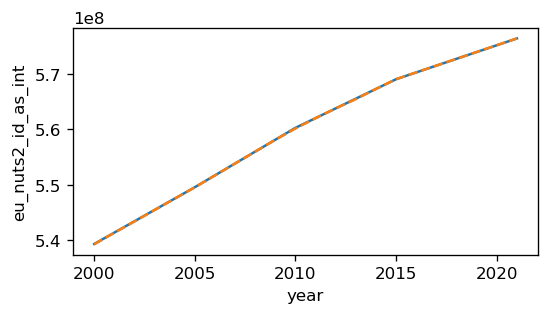

In [78]:
(pop_regrid * mask).sum(dim=['latitude', 'longitude']).plot()
demographics.sum(dim=['latitude', 'longitude', 'age_band_lower_bound']).plot( linestyle='dashed')

## Estimate the distribution of newborns by:

> NOTE: for Eurostat data, instead use directly the number of birthds (otherwise birth rate is given per woman). use the live births by age and agg as needed otherwise is given at NUTS3 level instead of NUTS2 (could be extended later)


births = country_pop * CBR

deaths = IMR * births

infants = births - deaths = births * (1 - (IMR / 1000)

(by NUTS region)

> NOTE: make sure to forward and backfill data since missing for many countries

Get the gridded number of under 5s for each country

Calculate a gridded weight by dividing by the sum of the under 5s for each country-> using the GPW data so just for 2010

$\Sigma w_i * c_i = c_{total}$ 
$\Sigma w_i = 1$ 




Calculate the total number of newborns for a country as CBR * country pop (technically should be related to the total Births value, but the latter seems to be total over 5 years so anyway need to dick about to estimate for one year)

Calculate the gridded number of newborns per cell using the weights 

$w_i * b$




In [84]:
eu_imr = pd.read_table('demo_r_minfind.tsv.gz')
eu_imr = prep_eurostat_table(eu_imr).loc['RT']

In [85]:
eu_births = pd.read_table('demo_r_fagec.tsv.gz')
eu_births = prep_eurostat_table(eu_births).loc['NR'].loc['TOTAL']

In [86]:
eu_imr = eu_imr.ffill(axis=1).bfill(axis=1)
eu_births = eu_births.ffill(axis=1).bfill(axis=1)

In [87]:
eu_infants = eu_births * (1 - (eu_imr / 1000))

eu_infants.index.name = 'nuts'

In [88]:
eu_infants_x = eu_infants.to_xarray().to_array('year')

eu_infants_x = eu_infants_x.interp({'year':np.arange(2000, 2022)}, kwargs=dict(fill_value='extrapolate'))

In [89]:
infants = xr.DataArray(
    np.zeros((
        len(pop_regrid.year),
        len(pop_regrid.latitude), 
        len(pop_regrid.longitude),
        )),
    coords=[
        pop_regrid.year,
        pop_regrid.latitude,
        pop_regrid.longitude, 
    ],
    name='infants'
)

for _, row in tqdm(nuts2.iterrows(), total=len(nuts2)):
    mask = raster_nuts_grid == row.id_as_int
    
    n_infants = eu_infants_x.sel(year=demographics.year,nuts=row.id, drop=True)
    
    # extract demographics and turn into spatial weights
    weights = (demographics.sel(age_band_lower_bound=0).where(mask))
    weights = weights / weights.sum()

    # multiply wieghts with infant number
    weighted_infances = n_infants * weights      
    infants = xr.where(mask, weighted_infances, infants)

  0%|          | 0/327 [00:00<?, ?it/s]

In [90]:
infants.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'infants_number.nc')

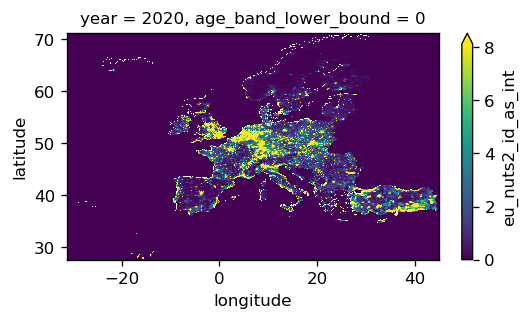

In [90]:
infants.sel(year=2020).plot(robust=True)

In [91]:
interactive_map(infants)

interactive(children=(IntSlider(value=2021, description='year', max=2021, min=2000), Output()), _dom_classes=(…

# Calculate exposures -> changes and totals

TODO also need to do the per-nuts calculations with the mask. Can use 2021 version for consistency.

In [91]:
heatwave_exposure_over65 = demographics.sel(age_band_lower_bound=65) * heatwave_days_delta_eu.heatwaves_days

heatwave_exposure_infants = infants * heatwave_days_delta_eu.heatwaves_days

heatwave_exposure_change = xr.concat([
    heatwave_exposure_infants.expand_dims({'age_band':['LT_1']}),
    heatwave_exposure_over65.expand_dims({'age_band':['GT_65']})],
    'age_band').drop('age_band_lower_bound')

In [92]:
heatwave_exposure = xr.concat([
    (infants * heatwave_days_eu).expand_dims({'age_band':['LT_1']}),
    ( demographics.sel(age_band_lower_bound=65) * heatwave_days_eu).expand_dims({'age_band':['GT_65']})],
    'age_band').drop('age_band_lower_bound')


In [93]:
heatwave_exposure_change.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_exposure_change_total_eu.nc')
heatwave_exposure.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_exposure_total_eu.nc')

In [26]:
heatwave_exposure_change = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_exposure_change_total_eu.nc')
heatwave_exposure = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'heatwave_exposure_total_eu.nc')

In [27]:
mask = (heatwave_exposure.sum(dim='age_band').max(dim='year').heatwaves_days>0)

In [20]:
heatwave_exposure_change.where(mask).to_dataframe().dropna().to_csv(RESULTS_FOLDER / 'heatwave_exposure_change_grid_eu.csv.zip')
heatwave_exposure.where(mask).heatwaves_days.to_dataframe().dropna().to_csv(RESULTS_FOLDER / 'heatwave_exposure_total_grid_eu.csv.zip')

KeyboardInterrupt: 

In [31]:
(heatwave_exposure_change
 .sum(dim=['latitude', 'longitude'])
 .to_dataframe('exposures')
 .unstack()
 .T
 .loc['exposures']
 .to_csv(RESULTS_FOLDER / 'exposure_change_eu.csv'))

In [32]:
(heatwave_exposure
 .heatwaves_days
 .sum(dim=['latitude', 'longitude'])
 .to_dataframe('exposures')
 .unstack()
 .T
 .loc['exposures']
 .to_csv(RESULTS_FOLDER / 'exposure_total_eu.csv'))

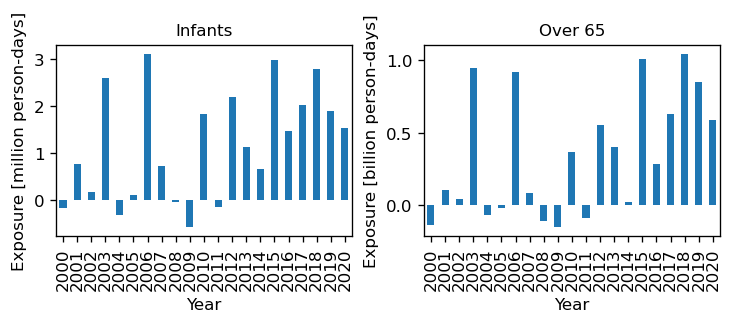

In [177]:
plot_data = heatwave_exposure_change.sum(dim=['latitude', 'longitude']).to_dataframe('exposures').unstack().T.loc['exposures']

fig = plt.figure(constrained_layout=True, figsize=(6, 2.5))
ax_array = fig.subplots(1, 2, squeeze=True)

(plot_data.LT_1 / 1e6).plot.bar(ax=ax_array[0])
ax_array[0].set(title='Infants', ylabel='Exposure [million person-days]', xlabel='Year')
(plot_data.GT_65/ 1e9).plot.bar(ax=ax_array[1])
ax_array[1].set(title='Over 65', ylabel='Exposure [billion person-days]', xlabel='Year')
fig.savefig(RESULTS_FOLDER / 'total exposure to change.png')

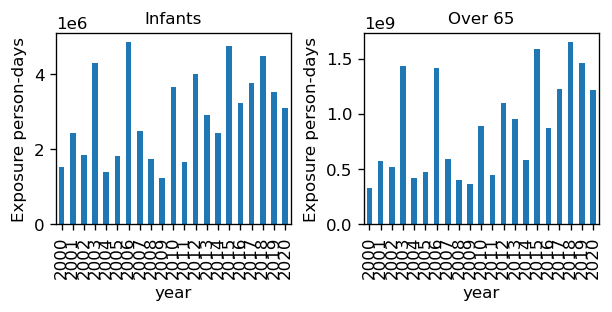

In [89]:
plot_data = heatwave_exposure.sum(dim=['latitude', 'longitude']).to_dataframe('exposures').unstack().T.loc['exposures']

fig = plt.figure(constrained_layout=True)
ax_array = fig.subplots(1, 2, squeeze=True)

plot_data.LT_1.plot.bar(stacked=True, ax=ax_array[0])
ax_array[0].set(title='Infants', ylabel='Exposure person-days')
plot_data.GT_65.plot.bar(stacked=True, ax=ax_array[1])
ax_array[1].set(title='Over 65', ylabel='Exposure person-days')
fig.savefig(RESULTS_FOLDER / 'total exposure.png')

In [335]:
interactive_map(heatwave_exposure_infants)

interactive(children=(IntSlider(value=2020, description='year', max=2020, min=2000), Output()), _dom_classes=(…

In [332]:
interactive_map(heatwave_exposure_over65)

interactive(children=(IntSlider(value=2020, description='year', max=2020, min=2000), Output()), _dom_classes=(…

In [94]:
shapefile = Path('.') / 'shapefiles/NUTS_RG_03M_2021_4326_clipped.geojson'
nuts_2021 = gpd.read_file(shapefile)

In [95]:
nuts_2021 = nuts_2021[nuts_2021.LEVL_CODE == 2]
nuts_2021['id_as_int'] = nuts_2021.id.str.encode("utf-8").apply(lambda b: np.frombuffer(b, dtype='>u4')[0]).astype(np.uint32)
nuts_2021 = nuts_2021.set_index('id')

In [96]:
north = heatwave_days_delta_eu.latitude[0].item()
west = heatwave_days_delta_eu.longitude[0].item()

ysize = -(heatwave_days_delta_eu.latitude[1] - heatwave_days_delta_eu.latitude[0]).item()
xsize = (heatwave_days_delta_eu.longitude[1] - heatwave_days_delta_eu.longitude[0]).item()

transform = rasterio.transform.from_origin(west, north, xsize, ysize)

image = features.rasterize(
            [(row.geometry, row.id_as_int) for idx, row in nuts_2021.iterrows()],
            out_shape=heatwave_days_delta_eu.heatwaves_days.shape[1:],
            transform=transform,
    dtype=np.uint32
)

# Make NetCDF matching the heatwave data
raster_nuts_2021_grid = xr.DataArray(image, 
                                {'latitude': heatwave_days_delta_eu.latitude, 
                                 'longitude':heatwave_days_delta_eu.longitude, 
                                },
                                name='eu_nuts2_id_as_int'
                               )


In [97]:
summary_change = {}
for nuts_code, row in tqdm(nuts_2021.iterrows(), total=len(nuts_2021)):
    mask = raster_nuts_2021_grid == row.id_as_int
    
    exp = heatwave_exposure_change.where(mask).sum(dim=['latitude','longitude'])
    exp.name = nuts_code
    summary_change[nuts_code] = exp

summary_change = xr.merge(summary_change.values()).to_array('nuts')
summary_change.name = 'exposures_to_change'

  0%|          | 0/329 [00:00<?, ?it/s]

In [98]:
summary = {}
for nuts_code, row in tqdm(nuts_2021.iterrows(), total=len(nuts_2021)):
    mask = raster_nuts_2021_grid == row.id_as_int
    
    exp = heatwave_exposure.where(mask).sum(dim=['latitude','longitude'])
    exp.name = nuts_code
    summary[nuts_code] = exp

summary = xr.merge(summary.values()).to_array('nuts')
summary.name = 'exposures'

  0%|          | 0/329 [00:00<?, ?it/s]

AttributeError: cannot set attribute 'name' on a 'Dataset' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

## Export Summary

In [161]:
summary_change.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'exposure_change_by_nuts2021.nc')

In [159]:
summary.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'exposure_totals_by_nuts2021.nc')

In [8]:
summary = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'exposure_totals_by_nuts2021.nc')

In [165]:
summary_change.to_dataframe().reset_index().to_csv(RESULTS_FOLDER / 'exposure_change_by_nuts2021.csv')
summary.to_dataframe().reset_index().to_csv(RESULTS_FOLDER / 'exposure_totals_by_nuts2021.csv')

## Exploring different visualisations

<AxesSubplot:>

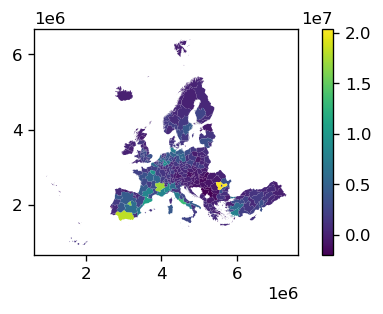

In [467]:
nuts_2021['plot_var'] = summary.sel(year=2020, age_band='GT_65').to_dataframe().exposures
nuts_2021.to_crs("EPSG:3035").plot('plot_var', legend=True)

In [618]:
baseline = summary.sel(year=slice(2000, 2009)).sum(dim='age_band').mean(dim='year')
summary_pct = 100 * (summary.sel(year=slice(2010, 2019)).sum(dim='age_band').mean(dim='year') - baseline) / baseline

In [101]:
heatwave_exposure = heatwave_exposure.heatwaves_days

In [118]:
decade_change = (100 * 
                 (heatwave_exposure.sel(year=slice(2010, 2019)).mean(dim='year') - heatwave_exposure.sel(year=slice(2000, 2009)).mean(dim='year'))
                 / heatwave_exposure.sel(year=slice(2000, 2009)).mean(dim='year')
                )

In [120]:
decade_change.sel(age_band='GT_65').max()

<xarray.DataArray 'heatwaves_days' ()>
array(4542.48932196)
Coordinates:
    age_band  <U5 'GT_65'

In [121]:
decade_change.sel(age_band='GT_65').quantile([0.95, 0.99])

<xarray.DataArray 'heatwaves_days' (quantile: 2)>
array([157.44003426, 237.85003911])
Coordinates:
  * quantile  (quantile) float64 0.95 0.99

In [116]:
print(f'''
Heatwaves person-days

mean 2000 - 2009 all groups: {heatwave_exposure.sel(year=slice(2000, 2009)).sum(dim='age_band').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

mean 2000 - 2009 over 65: {heatwave_exposure.sel(year=slice(2000, 2009)).sel(age_band='GT_65').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

mean 2000 - 2009 under 1: {heatwave_exposure.sel(year=slice(2000, 2009)).sel(age_band='LT_1').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

mean 2010 - 2019 all groups: {heatwave_exposure.sel(year=slice(2010, 2019)).sum(dim='age_band').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

mean 2010 - 2019 over 65: {heatwave_exposure.sel(year=slice(2010, 2019)).sel(age_band='GT_65').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

mean 2010 - 2019 under 1: {heatwave_exposure.sel(year=slice(2010, 2019)).sel(age_band='LT_1').sum(dim=['latitude','longitude']).mean(dim='year').item():.3g}

''')



Heatwaves person-days

mean 2000 - 2009 all groups: 6.53e+08

mean 2000 - 2009 over 65: 6.51e+08

mean 2000 - 2009 under 1: 2.36e+06

mean 2010 - 2019 all groups: 1.08e+09

mean 2010 - 2019 over 65: 1.07e+09

mean 2010 - 2019 under 1: 3.44e+06




In [636]:
heatwave_exposure.sel(year=2020).sum(dim=['latitude','longitude'])

<xarray.DataArray (age_band: 2)>
array([3.10687338e+06, 1.21228511e+09])
Coordinates:
  * age_band  (age_band) <U5 'LT_1' 'GT_65'
    year      int64 2020

In [608]:
decade_change.mean(dim=['latitude', 'longitude'])

<xarray.DataArray (age_band: 2)>
array([32.31516339, 57.3089201 ])
Coordinates:
  * age_band  (age_band) <U5 'LT_1' 'GT_65'

In [609]:
decade_change.quantile(0.95, dim=['latitude', 'longitude'])

<xarray.DataArray (age_band: 2)>
array([127.86091834, 157.44003426])
Coordinates:
  * age_band  (age_band) <U5 'LT_1' 'GT_65'
    quantile  float64 0.95

In [149]:
decade_change_sum = (100 * 
                 (heatwave_exposure.sel(year=slice(2010, 2019)).sum(dim='age_band').mean(dim='year') - heatwave_exposure.sel(year=slice(2000, 2009)).sum(dim='age_band').mean(dim='year'))
                 / heatwave_exposure.sel(year=slice(2000, 2009)).sum(dim='age_band').mean(dim='year')
                )

In [150]:
decade_change_sum.mean(dim=['latitude', 'longitude'])

<xarray.Dataset>
Dimensions:         ()
Data variables:
    heatwaves_days  float64 57.21

In [93]:
decade_change_sum.quantile(0.95, dim=['latitude', 'longitude'])

<xarray.DataArray ()>
array(157.14725744)
Coordinates:
    quantile  float64 0.95

In [145]:
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature

In [164]:
divnorm = colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=250)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


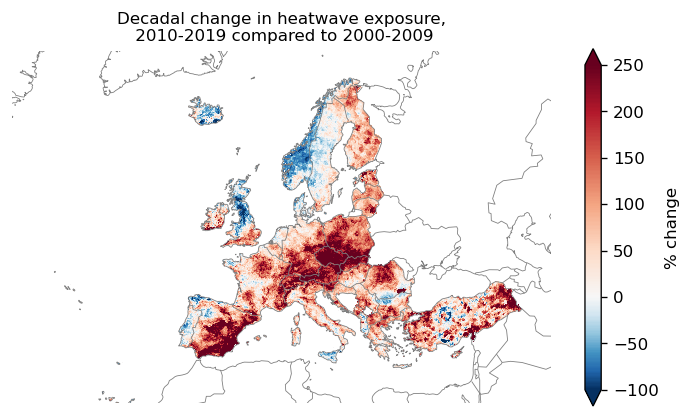

In [173]:
f = plt.figure(figsize=(6,3.5))
# ax = f.add_subplot()
ax = plt.axes(projection=ccrs.epsg(3035),  frameon=False)

plot_data = decade_change.sum(dim='age_band')
plot_data = plot_data.where(raster_nuts_grid > 0)

plot_data.plot.pcolormesh(
    norm=divnorm,
#     vmin=-100, vmax=300,  cmap='plasma',
               ax=ax, 
               cbar_kwargs={'label': '% change'},
               transform=ccrs.PlateCarree()
              )
ax.coastlines(resolution='50m', color='grey', linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)
ax.spines['geo'].set_visible(False)

ax.set(title='Decadal change in heatwave exposure,\n 2010-2019 compared to 2000-2009') 
plt.tight_layout()

f.savefig(RESULTS_FOLDER / 'decade exposure change pct map.png', dpi=600)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


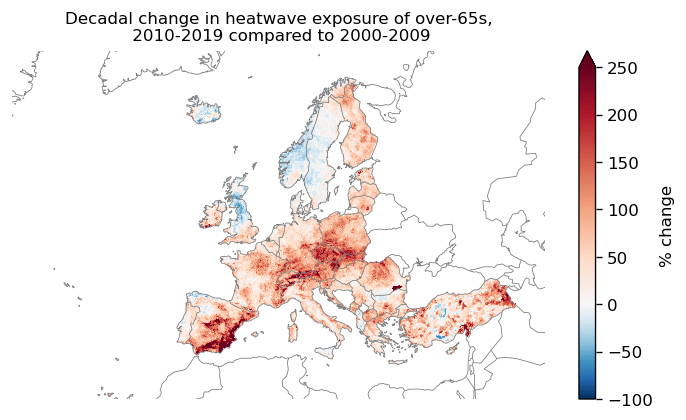

In [174]:
f = plt.figure(figsize=(6,3.5))
ax = plt.axes(projection=ccrs.epsg(3035),  frameon=False)

plot_data = decade_change.sel(age_band='GT_65')
plot_data = plot_data.where(raster_nuts_grid > 0)

plot_data.plot(
#         vmin=-100, vmax=200,  cmap='plasma',
    norm=divnorm,
               ax=ax, 
               cbar_kwargs={'label': '% change'},
               transform=ccrs.PlateCarree()
              )
ax.coastlines(resolution='50m', color='grey', linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)
ax.set( title='Decadal change in heatwave exposure of over-65s,\n 2010-2019 compared to 2000-2009')
ax.spines['geo'].set_visible(False)
plt.tight_layout()

f.savefig(RESULTS_FOLDER / 'decade exposure gt65 change pct map.png', dpi=600)

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


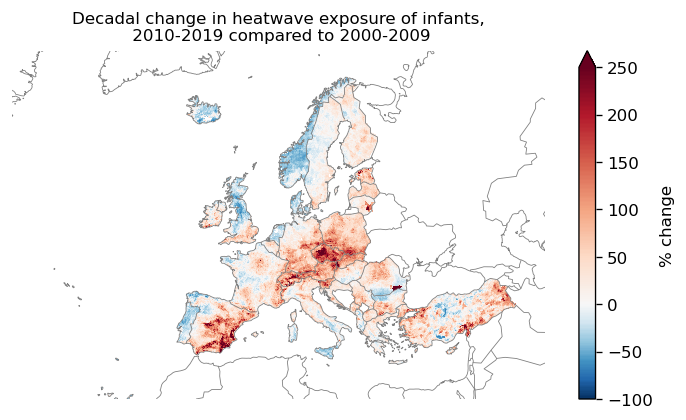

In [176]:
f = plt.figure(figsize=(6,3.5))
ax = plt.axes(projection=ccrs.epsg(3035),  frameon=False)

# nuts_2021.plot(facecolor='none', ax=ax)
plot_data = decade_change.sel(age_band='LT_1')
plot_data = plot_data.where(raster_nuts_grid > 0)

plot_data.plot(
#         vmin=-100, vmax=200,  cmap='plasma',
    norm=divnorm,
    ax=ax, 
               cbar_kwargs={'label': '% change'},
               transform=ccrs.PlateCarree()
              )
ax.coastlines(resolution='50m', color='grey', linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)
ax.set(title='Decadal change in heatwave exposure of infants,\n 2010-2019 compared to 2000-2009')
ax.spines['geo'].set_visible(False)
plt.tight_layout()

f.savefig(RESULTS_FOLDER / 'decade exposure lt1 change pct map.png', dpi=600)

In [10]:
# pop_2018 = xr.open_dataset('shapefiles/JRC_1K_POP_2018.tif', decode_cf=True)